In [1]:
import os 
from pathlib import Path
import torch
from transformers import *
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True,
                                        output_attentions=False)

In [7]:
import pandas as pd
def gen_wordlist(len_wordlist=60):
    """Generates wordlist as opposed to sentences in the Ding data.

    output structure:    "w1 w2 w3 w4."
    """
    full_ding = pd.read_csv(str(Path(os.getcwd()).parent) + '\\Data\\Ding_grammatical.csv',
                           header=None)
    # get all nouns
    nouns = pd.unique(pd.concat([full_ding[1],full_ding[3]]))
    adjectives = pd.unique(full_ding[0])
    verbs = pd.unique(full_ding[2])
    all_words = np.unique(np.concatenate([nouns,adjectives,verbs]))
    word_salad_seqs = []
    for i in range(60):
        word_salad = np.random.choice(all_words,size=4,replace=False)
        word_salad_seq = ' '.join(word_salad) #+ '.'
        word_salad_seqs.append(word_salad_seq)
    jabberwocky_seqs = []
    for i in range(60):
        jabberwocky = np.random.choice(adjectives,size=1) + ' ' + np.random.choice(nouns,size=1) + ' ' + \
            np.random.choice(verbs,size=1) + ' ' + np.random.choice(nouns,size=1)# + '.'
        jabberwocky_seqs.append(list(jabberwocky))
    jabberwocky_seqs = [i[0] for i in jabberwocky_seqs]
    np_seqs = []
    for i in range(60):
        np_seq = np.random.choice(adjectives,size=1) + ' ' + np.random.choice(nouns,size=1) + ' ' + \
            np.random.choice(adjectives,size=1) + ' ' + np.random.choice(nouns,size=1)# + '.'
        np_seqs.append(list(np_seq))
    np_seqs = [i[0] for i in np_seqs]
    vp_seqs = []
    for i in range(60):
        vp_seq = np.random.choice(verbs,size=1) + ' ' + np.random.choice(nouns,size=1) + ' ' + \
            np.random.choice(verbs,size=1) + ' ' + np.random.choice(nouns,size=1) #+ '.'
        vp_seqs.append(list(vp_seq))
    vp_seqs = [i[0] for i in vp_seqs]
    # keep random pattern - say - verb, noun, noun, adjective
    random_patterns = []
    for i in range(60):
        random_pattern = np.random.choice(verbs,size=1) + ' ' + np.random.choice(nouns,size=1) + ' ' + \
            np.random.choice(nouns,size=1) + ' ' + np.random.choice(adjectives,size=1) #+ '.'
        random_patterns.append(list(random_pattern))
    random_patterns = [i[0] for i in random_patterns]

    return [word_salad_seqs,jabberwocky_seqs,np_seqs,vp_seqs,random_patterns]

In [8]:
# read sentences : 
sentences = []
with open(str(Path(os.getcwd()).parent) + '\\Data\\Ding_grammatical.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        sentences.append(' '.join(row))
        #sentences[-1] = sentences[-1] + '.'
        #print(sentences[-1])
#temp = torch.load("/Users/karthikeyakaushik/Documents/oscillating_rnn/Dyer/self-attentive-parser/data/en_charlstm_dev.93.61.pt")
#parser = parse_nk.NKChartParser.from_spec(temp['spec'], temp['state_dict'])

sentences = ' '.join(sentences)
sentences = sentences.split()

sjnv = gen_wordlist()
sjnv = [subitem for sublist in sjnv for subitem in sublist]
sjnv = ' '.join(sjnv)
sjnv = sjnv.split()
sjnv = sentences + sjnv
# sentences_all = sentences, sjnv[0:240] (word salad), sjnv[240:480] (jabberwocky), sjnv[480:720] (np), sjnv[720:960] (vp), sjnv[960:](random pattern) 

plot_names = {'valid_sentences':'Valid Sentences',
             'word_salad':'Word Salad',
             'jabberwocky': 'Jabberwocky',
             'noun_phrases':'Noun Phrases',
             'verb_phrases':'Verb Phrases',
             'random_pattern':'Random Pattern (v-n-n-a)'}
stimuli = ['valid_sentences','word_salad','jabberwocky','noun_phrases','verb_phrases','random_pattern']


#if 'UNK' in parser.tag_vocab.indices:
#    dummy_tag = 'UNK'
#else:
#    dummy_tag = parser.tag_vocab.value(0)
#subbatch_sentences = sentences_all
#subbatch_sentences = [[(dummy_tag, word) for word in sentences_all]]

In [9]:
def windowed_zscores(vals,window=10):
    scores = np.zeros(vals.shape)
    seq_length = vals.shape[0]
    for i in range(seq_length):
        # before window length is reached
        if i < window:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[0:i]]).mean()
        # less than window length remaining
        elif (i + window) > seq_length:
            scores[i] = vals[i] - np.concatenate([vals[i-window:i],vals[i+1:]]).mean()
        # after window length is reached
        else:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[i-window:i]]).mean()
    return scores

(126,) (126,)
(126,) (126,)
(124,) (124,)
(125,) (125,)
(126,) (126,)
(128,) (128,)


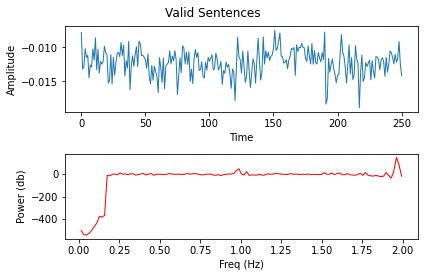

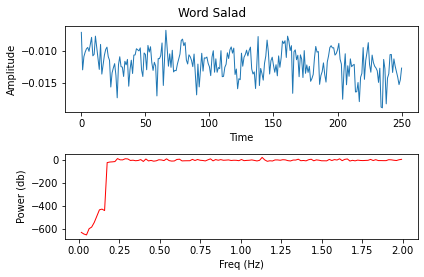

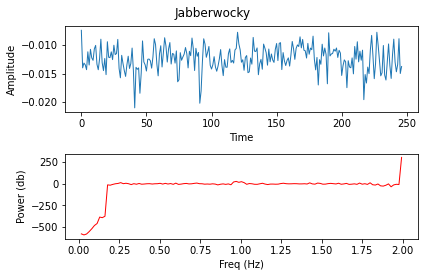

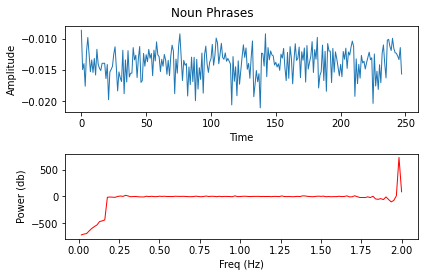

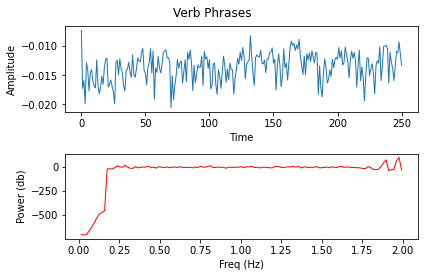

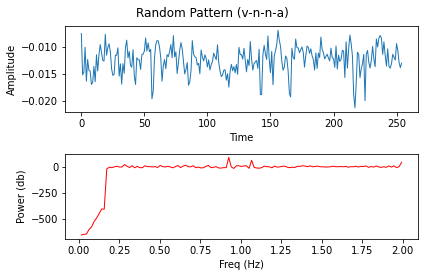

In [12]:
for i in range(0,6):
    sentences_all = sjnv[i*240:(i+1)*240]
    input_ids = torch.tensor([tokenizer.encode(' '.join(sentences_all), add_special_tokens=True)])
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]# Models outputs are now tuples
    #print(last_hidden_states.shape)
    temp_acts = last_hidden_states[0,:,:].numpy()
    freq, mean_power = power_spectra(temp_acts,sampling_rate=4)
    mean_power = windowed_zscores(mean_power,window=10)
    print(freq.shape,mean_power.shape)
    plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-bert-smoothed\\' + stimuli[i],  
             freq, mean_power, act=np.mean(temp_acts,axis=1),
             sampling_rate=4,n_samples=60,title=plot_names[stimuli[i]])


In [20]:
str(Path(os.getcwd()).parent) + '\\plots-bert-smoothed\\'

'C:\\Users\\karkau\\Documents\\karthikeya\\oscillating_rnn\\Dyer\\plots-bert-smoothed\\'

In [10]:
# power spectra function
def power_spectra(w2vec_array, sampling_rate=16):
    """Computes power spectra using the Discrete Fourier Transform.

    Args:
        w2vec_array: arrays of shape (n_sentences*time_steps, n_units)
            representing hidden layer activations in response to each word of the
            concatenated sequence of sentences.
        sample_rate: number of measures (outputs of the model) per second.

    Returns:
        Mean power spectra and frequency axis.
    """

    # Separate each unit and concatenate across words to form 1 vector per unit
    unit_vectors = np.transpose(w2vec_array)

    # Frequency domain
    # num_samples is just the number of data points for each unit
    num_samples = unit_vectors.shape[1]
    freq = np.fft.rfftfreq(num_samples, d=1./sampling_rate)
    #print ('freq ' ,freq.shape)
    # Calculate the FFT and power spectra for each unit
    units_ps = []
    for vector in unit_vectors:
        ft_unit = np.fft.rfft(vector)  # fft
        ps_uni = np.abs(ft_unit) ** 2  # power spectrum
        units_ps.append(ps_uni)

    # Average power spectra over units
    mean_ps = np.mean(units_ps, axis=0)
    #print ('mean_ps',mean_ps.shape)
    return freq, mean_ps

In [11]:
def plot_results(plot_name, freq, power, act,sampling_rate=16,n_samples=60,title='Input stimuli'):
    """Plot all the results of one condition"""
    plt.rcParams['pdf.fonttype'] = 42 # for the eps files
    plt.rcParams['ps.fonttype'] = 42

    # Time domain parameters
    sampling_interval = 1.0/sampling_rate  # sampling interval
    t = np.arange(0, len(act))  # time vector
    # Build plot
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.suptitle(title)
    ax[0].plot(t, act, linewidth=1.0)
    # Axis labels
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    #until_4 = np.where(freq==4)[0][0]
    #print('Power difference ')
    ax[1].plot(freq[1:], power[1:], 'r', linewidth=1.0)
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('Power (db)')
    # Adjusts subplot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save
    fig.savefig(plot_name+'.pdf',format='pdf')
